In [9]:
import numpy as np
import pathlib
import time
import h5py
import obspy
import types
import pyasdf
import pickle
import rasterio
import math
from datetime import datetime
from scipy.signal import butter
from scipy.signal import filtfilt
import matplotlib.pyplot as plt
from detection.stalta_detector import stalta_detector
from detection.master_event_correlation import correlate_master
from detection.master_event_correlation import threshold_detections
from detection.master_event_correlation import plot_catalog
from detection.template_match import make_templates
from detection.template_match import template_match
from detection.template_match import detection_timeseries
from clustering.clustering import get_input_waveforms
from clustering.clustering import load_waveform
from clustering.clustering import cluster_events
from clustering.clustering import plot_clusters
from location.compute_backazimuths_dev import compute_backazimuths
from location.compute_backazimuths_dev import get_station_coordinates
from location.compute_backazimuths_dev import get_station_grid_locations
from figures.figures import plot_backazimuths_on_imagery
from figures.figures import plot_events_and_gps
from figures.figures import get_stacks
from gps.gps import gps_ice_velocity
from pyproj import Proj,transform
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from datetime import datetime
from datetime import timedelta
from matplotlib.dates import date2num
from matplotlib.dates import DateFormatter
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Proj,transform,Geod
import pyproj

In [10]:
'''

Download data and remove instrumental response

'''

# specify path to save data- folders will be created in this directory
data_path = "/media/Data/Data/PIG/MSEED/"
xml_path = "/media/Data/Data/PIG/XML/HH/"

# pull the data from IRIS servers

# remove instrumental response

# update path to data so subsequent cells will use data with the instrumental response removed
data_path = data_path + "noIR/"

In [14]:
'''

Compute backazimuths for all events in the catalog

'''

# load catalog
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')

# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()
l.win_len = 10
l.slide = 5
l.trace_len = 500
l.num_steps = int((l.trace_len-l.win_len)/l.slide)
l.stations = ["PIG1","PIG2","PIG3","PIG4","PIG5"]
l.network = "XC"
l.crs = "EPSG:3245"

# set signal-to-noise ratio for throwing out stations in backazimuth computation
l.snr_threshold = 0

# set sta/lta ratio for throwing out individual windows in backazimuth computation
l.stalta_threshold = 1

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000
l.freq = [0.05,1]
l.fs = 100

# specify paths to data and me tadata
l.data_path = data_path
l.xml_path = xml_path
l.filename = "outputs/locations/new_catalog_PIG1_PIG2_PIG3_PIG4_PIG5_sector_pca_fixed_centroid.pickle"
l.n_procs = 18

# load the results of polarization analysis
baz_file = open(l.filename, "rb")
b = pickle.load(baz_file)
baz_file.close()
backazimuths = b.backazimuths

In [15]:
# load clustering results
cluster_file = h5py.File("outputs/clustering/2_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

backazimuths = backazimuths[predictions == 1]

In [ ]:
# open LANDSAT imagery file and plot as it is, in EPSG:3031
original_file = "data/imagery/LC08_L1GT_001113_20131012_20170429_01_T2_B4.TIF"
sat_imagery = rasterio.open(original_file)

p2 = Proj("EPSG:3031",preserve_units=False)
p1 = Proj(proj='latlong',preserve_units=False)

fig,ax = plt.subplots(figsize=(10,10))
show(sat_imagery,ax=ax,cmap="gray")

In [ ]:
# transform into wgs84, then plot
dst_crs = 'wgs84'

with rasterio.open(original_file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('data/imagery/test_lon_lat.TIF', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

            
fig,ax = plt.subplots(figsize=(20,20))
file = "data/imagery/test_lon_lat.TIF"
test_imagery = rasterio.open(file)
show(test_imagery)
mid_lon = (test_imagery.bounds[2]-test_imagery.bounds[0])/2
print(test_imagery.bounds[0]+mid_lon)

In [ ]:
# transform into wgs84, then extract the actual data and use the m per degree lat and lon conversion to get the imagery in a north-oriented grid with unit of meters
# note: because we converted to wgs84, there are more x data points in the grid (larger second dimension) because the map 
# spans a larger longitudinal extent, even though it's the same actual distance, because degree lat and lon are not equal. We can use our converison factors
# for m per degree to then correct this with "extent," but this makes thinking about backazimuths tricky 

dst_crs = 'wgs84'

with rasterio.open(original_file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('data/imagery/test_lon_lat.TIF', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

            
l.station_lon_lat_coords = get_station_coordinates(l)
l.array_centroid = np.mean(l.station_lon_lat_coords,axis=0)
geod = Geod(ellps="WGS84")
m_per_lon = geod.line_length([l.array_centroid[0]-0.5,l.array_centroid[0]+0.5],[l.array_centroid[1],l.array_centroid[1]])
m_per_lat = geod.line_length([l.array_centroid[0],l.array_centroid[0]],[l.array_centroid[1]-0.5,l.array_centroid[1]+0.5])
            
fig,ax = plt.subplots(figsize=(20,20))
file = "data/imagery/test_lon_lat.TIF"
test_imagery = rasterio.open(file)
bounds = test_imagery.bounds
delta_lon = abs(bounds[0]-bounds[2])
delta_lat = abs(bounds[1]-bounds[3])
delta_x = delta_lon*m_per_lon
delta_y = delta_lon*m_per_lat
data = test_imagery.read(1)
plot_len = max(delta_x,delta_y)
ax.imshow(data[math.floor(0.3*data.shape[0]):math.floor(0.7*data.shape[0]),math.floor(0.3*data.shape[1]):math.floor(0.7*data.shape[1])],cmap='gray',extent=[math.floor(0.3*plot_len),math.floor(0.7*plot_len),math.floor(0.3*plot_len),math.floor(0.7*plot_len)])
plt.show()

In [ ]:
# try plotting in the nearest utm zone using rasterio plotting tools
# pretty close to above but less control 

dst_crs = 'epsg:32714'

with rasterio.open(original_file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('data/imagery/test_epsg_32714.TIF', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

fig,ax = plt.subplots(figsize=(10,10))
file = "data/imagery/test_epsg_32714.TIF"
test_epsg_imagery = rasterio.open(file)
show(test_epsg_imagery)

In [ ]:
# plot the utm version with imshow so we can zoom and compare to the wgs84 version above
# this one has the advantage of have properly-scaled axes from the beginning

file = "data/imagery/test_epsg_32714.TIF"
test_epsg_imagery = rasterio.open(file)

fig,ax = plt.subplots(figsize=(20,20))
data = test_epsg_imagery.read(1)
bounds = test_epsg_imagery.bounds
plot_bounds = [math.floor(0.3*data.shape[0]),math.floor(0.3*data.shape[1]),math.floor(0.7*data.shape[0]),math.floor(0.7*data.shape[1])]
ax.imshow(data[plot_bounds[0]:plot_bounds[2],plot_bounds[1]:plot_bounds[3]],cmap='gray',extent=bounds[:])
plt.show()

In [ ]:
# try plotting in WGS 84 / SCAR IMW SS13-15 using rasterio plotting tools
# pretty close to above but less control 

dst_crs = 'epsg:3245'

with rasterio.open(original_file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('data/imagery/test_epsg_3245.TIF', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

fig,ax = plt.subplots(figsize=(10,10))
file = "data/imagery/test_epsg_3245.TIF"
test_epsg_imagery = rasterio.open(file)
show(test_epsg_imagery)

In [ ]:
# plot the WGS 84 / SCAR IMW SS13-15 version with imshow so we can zoom and compare to the wgs84 version above
# this one has the advantage of have properly-scaled axes from the beginning

file = "data/imagery/test_epsg_3245.TIF"
test_epsg_imagery = rasterio.open(file)

fig,ax = plt.subplots(figsize=(20,20))
data = test_epsg_imagery.read(1)
bounds = test_epsg_imagery.bounds
plot_bounds = [math.floor(0.3*data.shape[0]),math.floor(0.3*data.shape[1]),math.floor(0.7*data.shape[0]),math.floor(0.7*data.shape[1])]
ax.imshow(data[plot_bounds[0]:plot_bounds[2],plot_bounds[1]:plot_bounds[3]],cmap='gray',extent=bounds[:])
plt.show()

In [ ]:
def get_station_locations(station_lon_lat_coords):
    # convert station coordinates to x and y and take average station location
    p2 = Proj("EPSG:3245",preserve_units=False)
    p1 = Proj(proj='latlong',preserve_units=False)
    [stat_x,stat_y] = pyproj.transform(p1,p2,station_lon_lat_coords[:,0],station_lon_lat_coords[:,1])
    return np.transpose(np.array([stat_x,stat_y]))

In [ ]:
def compute_rays(angle):
    ray = np.zeros((1,2),'float64')
    if angle >= 0 and angle < 90:
        ray[0,0] = np.sin(angle*np.pi/180)
        ray[0,1] = np.cos(angle*np.pi/180)
    if angle >= 90 and angle < 180:
        ray[0,0] = np.sin((angle-90)*np.pi/180)
        ray[0,1] = -1*np.cos((angle-90)*np.pi/180)
    if angle >= 180 and angle < 270:
        ray[0,0] = -1*np.sin((angle-180)*np.pi/180)
        ray[0,1] = -1*np.cos((angle-180)*np.pi/180)
    if angle >= 270 and angle < 360:
        ray[0,0] = -1*np.sin((angle-270)*np.pi/180)
        ray[0,1] = np.cos((angle-270)*np.pi/180)
    return ray

In [ ]:
# open LANDSAT imagery file and plot as it is, in EPSG:3031
original_file = "data/imagery/test_epsg_3245.TIF"

sat_imagery = rasterio.open(original_file)

# get station locations and array centroids
l.station_lon_lat_coords = get_station_coordinates(l)
l.station_grid_coords = get_station_grid_locations(l)
array_centroid = np.mean(l.station_grid_coords,axis=0)

# get corners of imagery extent
corners = np.array([[sat_imagery.bounds[0],sat_imagery.bounds[1]],   # bottom left
                    [sat_imagery.bounds[0],sat_imagery.bounds[3]],   # top left
                    [sat_imagery.bounds[2],sat_imagery.bounds[1]],   # bottom right
                    [sat_imagery.bounds[2],sat_imagery.bounds[3]]])  # top right
p2 = Proj("EPSG:3245",preserve_units=False)
p1 = Proj(proj='latlong',preserve_units=False)
corners_lon,corners_lat = pyproj.transform(p2,p1,corners[:,0],corners[:,1])

# make plots
fig,ax = plt.subplots(figsize=(20,20))

# plot imagery
bounds = sat_imagery.bounds
ax.imshow(sat_imagery.read(1),cmap='gray',extent=[bounds[0],bounds[2],bounds[1],bounds[3]])

# define, transform, and plot lat/lon grid
lat = [-74,-75]
lon = [-98,-100,-102,-104]
x_lab_pos=[]
y_lab_pos=[]
line = np.linspace(corners_lon[0]-1,corners_lon[2]+1,100)
for i in lat:
    line_x,line_y = transform(p1,p2,line,np.linspace(i,i,100))
    ax.plot(line_x,line_y,linestyle='--',linewidth=0.5,c='gray',alpha=1)
    y_lab_pos.append(line_y[np.argmin(np.abs(line_x-corners[0,0]))])
line = np.linspace(corners_lat[0]-2,corners_lat[1]+1,100)
for i in lon:
    line_x,line_y = transform(p1,p2,np.linspace(i,i,100),line)
    ax.plot(line_x,line_y,linestyle='--',linewidth=0.5,c='gray',alpha=1)
    x_lab_pos.append(line_x[np.argmin(np.abs(line_y-corners[0,1]))])
ax.set_xlim([corners[0,0],corners[2,0]])
ax.set_ylim([corners[0,1],corners[1,1]])

# set ticks and labels for lat/lon grid
ax.set_xticks(x_lab_pos)
ax.set_xticklabels(labels=[str(lon[0]) + '$^\circ$',str(lon[1]) + '$^\circ$',str(lon[2]) + '$^\circ$',str(lon[3]) + '$^\circ$'])
ax.set_xlabel("Longitude")
ax.set_yticks(y_lab_pos)
ax.set_yticklabels(labels=[str(lat[0]) + '$^\circ$',str(lat[1]) + '$^\circ$'])
ax.set_ylabel("Latitude")

# colors
k1 = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
k2 = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

# plot station locations
ax.scatter(l.station_grid_coords[:,0],l.station_grid_coords[:,1],marker="^",c='black',zorder=10000)

# compute histogram of rift backazimuths
baz_hist, bins = np.histogram(backazimuths,bins=np.linspace(0,360,37))

#plot all rays in 10-degree bins with length proportional to # of windows in that bin
rays = np.zeros((36,2),'float64')
scale = 80000
max_width = 2*np.pi*scale/36
max_width = 7.5
for i in range(36):
    angle = i*10
    rays[i,:] = compute_rays(angle)
    rayLength = baz_hist[i]/max(baz_hist)*scale
    [x,y] = [np.linspace(array_centroid[0],array_centroid[0]+rays[i,0]*rayLength,100),
            np.linspace(array_centroid[1],array_centroid[1]+rays[i,1]*rayLength,100)]
    lwidths=np.linspace(0,max_width,100)*rayLength/scale
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, linewidths=lwidths,color="#d95f02",alpha=0.35,zorder=1000)
    ax.add_collection(lc)
    #plt.scatter(x,y)
    
plt.show()


In [47]:
# read the old backazimuths and plot them to confirm that plotting is working just fine
# read in backazimuths for catalog
azimuth_file = h5py.File("/home/setholinger/Documents/Projects/PIG/detections/templateMatch/multiTemplate/run3/event_backazimuths.h5","r")
event_backazimuths = np.array(list(azimuth_file["weighted_circular_average_event_backazimuths"]))
azimuth_file.close()

# load the old clustering results
cluster_file = h5py.File("/home/setholinger/Documents/Projects/PIG/detections/templateMatch/multiTemplate/run3/short_3D_clustering/modified_k_shape/2/2_cluster_predictions_0.05-1Hz.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
cluster_file.close()

backazimuths = event_backazimuths[predictions == 1][-25000:-24000]

/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: This fun

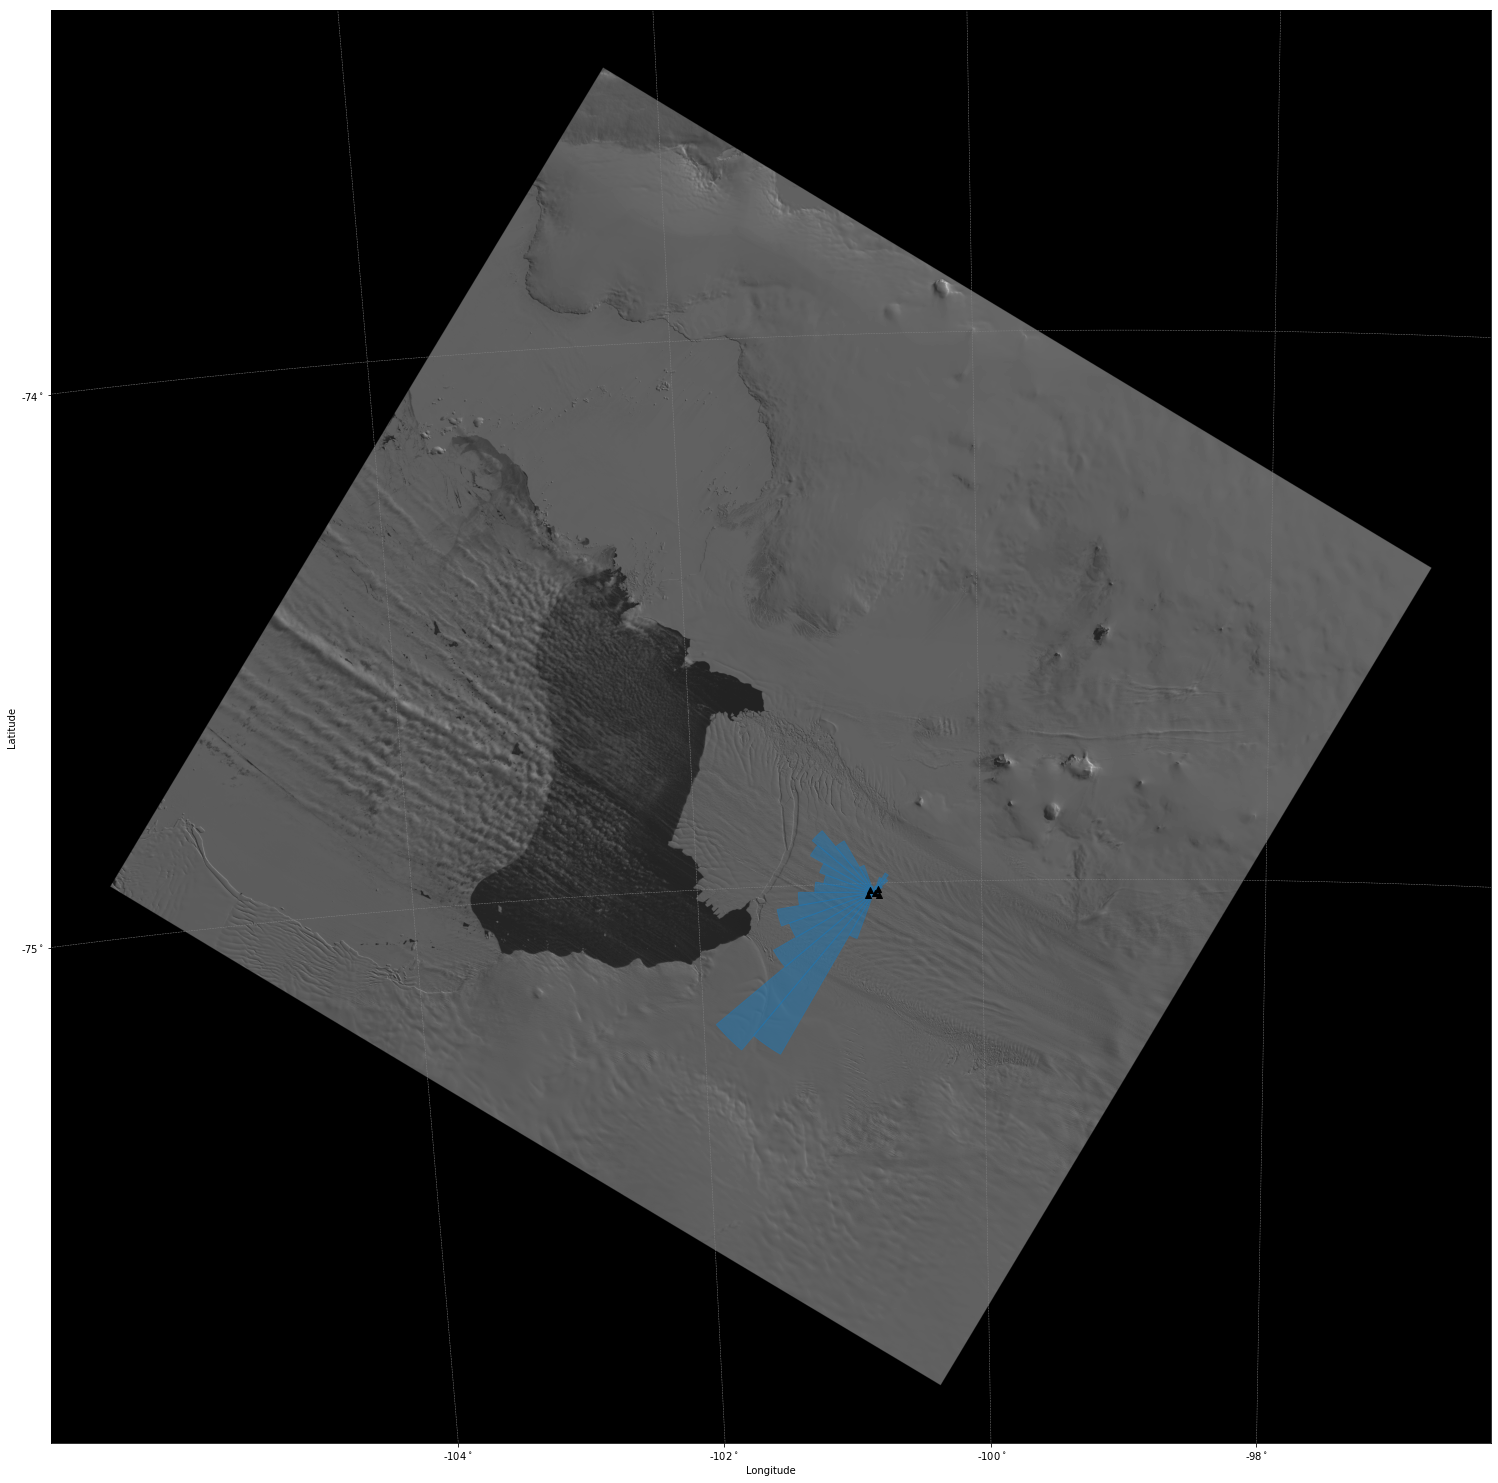

In [16]:
# get station locations and array centroids
l.station_lon_lat_coords = get_station_coordinates(l)
l.station_grid_coords = get_station_grid_locations(l)
array_centroid = np.mean(l.station_grid_coords,axis=0)

# open LANDSAT imagery file and plot as it is, in EPSG:3031
original_file = "data/imagery/test_epsg_3245.TIF"

sat_imagery = rasterio.open(original_file)
sat_data = sat_imagery.read(1)

# Construct figure and axis to plot on
fig,ax = plt.subplots(figsize=(20,20))

axes_coords = np.array([0, 0, 1, 1])

ax_image = fig.add_axes(axes_coords)

# get corners of imagery extent
p2 = Proj("EPSG:3245",preserve_units=False)
p1 = Proj(proj='latlong',preserve_units=False)

# plot imagery
bounds = sat_imagery.bounds
ax_image.imshow(sat_data,cmap='gray',extent=[bounds[0],bounds[2],bounds[1],bounds[3]])

# define, transform, and plot lat/lon grid
lat = [-74,-75]
lon = [-98,-100,-102,-104]
x_lab_pos=[]
y_lab_pos=[]
line = np.linspace(-110,-90,100)
for i in lat:
    line_x,line_y = transform(p1,p2,line,np.linspace(i,i,100))
    ax_image.plot(line_x,line_y,linestyle='--',linewidth=0.5,c='gray',alpha=1)
    y_lab_pos.append(line_y[np.argmin(np.abs(line_x-bounds[0]))])
line = np.linspace(-80,-70,100)
for i in lon:
    line_x,line_y = transform(p1,p2,np.linspace(i,i,100),line)
    ax_image.plot(line_x,line_y,linestyle='--',linewidth=0.5,c='gray',alpha=1)
    x_lab_pos.append(line_x[np.argmin(np.abs(line_y-bounds[1]))])
ax_image.set_xlim([bounds[0],bounds[2]])
ax_image.set_ylim([bounds[1],bounds[3]])

# set ticks and labels for lat/lon grid
ax_image.set_xticks(x_lab_pos)
ax_image.set_xticklabels(labels=[str(lon[0]) + '$^\circ$',str(lon[1]) + '$^\circ$',str(lon[2]) + '$^\circ$',str(lon[3]) + '$^\circ$'])
ax_image.set_xlabel("Longitude")
ax_image.set_yticks(y_lab_pos)
ax_image.set_yticklabels(labels=[str(lat[0]) + '$^\circ$',str(lat[1]) + '$^\circ$'])
ax_image.set_ylabel("Latitude")

# properly center the polar plot on the array centroid
l.station_lon_lat_coords = get_station_coordinates(l)
l.station_grid_coords = get_station_grid_locations(l)
array_centroid = np.mean(l.station_grid_coords,axis=0)
x_pos = (array_centroid[0]-sat_imagery.bounds[0])/(sat_imagery.bounds[2]-sat_imagery.bounds[0])
y_pos = (array_centroid[1]-sat_imagery.bounds[1])/(sat_imagery.bounds[3]-sat_imagery.bounds[1])
width = 0.3


ax_polar = fig.add_axes([x_pos-width/2,y_pos-width/2,width,width], projection = 'polar')
ax_polar.set_theta_zero_location('N')
ax_polar.set_theta_direction(-1)

n,bins = np.histogram(backazimuths[~np.isnan(backazimuths)]*np.pi/180,bins=np.linspace(0,2*np.pi,37))

# Compute width of each bin
widths = np.diff(bins)

# By default plot frequency proportional to area
# Area to assign each bin
area = n / backazimuths.size

# Calculate corresponding bin radius
#radius = (area/np.pi) ** .5
radius = n

# Plot data on ax
patches = ax_polar.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                 edgecolor='C0', fill=True, linewidth=1,alpha = .5)

# Remove ylabels for area plots (they are mostly obstructive)
ax_polar.set_yticks([])
ax_polar.axis('off')

# plot station locations
ax_stats = fig.add_axes(axes_coords)
ax_stats.scatter(l.station_grid_coords[:,0],l.station_grid_coords[:,1],marker="^",c='black')
ax_stats.set_xlim([bounds[0],bounds[2]])
ax_stats.set_ylim([bounds[1],bounds[3]])
ax_stats.axis('off')

#plt.show()
plt.savefig('outputs/locations/new_catalog_cluster_1_PIG1_PIG2_PIG3_PIG4_PIG5_sector_pca_fixed_centroid.png')